**Derivation of the training ansatz for the 4-call qubit-unitary inversion protocol**

In [1]:
import torch
from torch.nn import ModuleList

import quairkit
from quairkit.application import PQCombNet
from quairkit.circuit import Circuit
from quairkit.database import zero_state
from quairkit.qinfo import dagger

quairkit.set_dtype("complex128")

Set up the basic parameters of the training ansatz.

In [2]:
num_slots, ancilla_qubits = 4, 3
num_qubits = ancilla_qubits + 1
num_V = num_slots + 1
slot_dim = 2

Initial training ansatz that found 0.99 training fidelity, where each comb tooth is a 16-dimensional universal unitary tunable by 255 parameters.

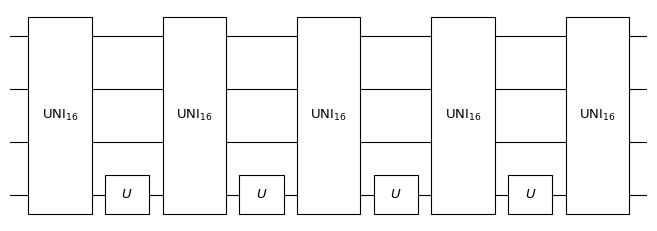

In [3]:
net = PQCombNet(
    target_function=dagger,
    num_slots=num_slots,
    ancilla=ancilla_qubits,
    slot_dim=slot_dim,
    train_mode="process",
)

net.plot()


In [4]:
net.train()

[pqcomb_dagger | process | 328809 | 0	0.0850s] slot_dim: 2, slots: 4, aux_qubits: 3, LR: 1.00e-01, Loss: 0.77169761
[pqcomb_dagger | process | 328809 | 100	0.0574s] slot_dim: 2, slots: 4, aux_qubits: 3, LR: 1.00e-01, Loss: 0.05178548
[pqcomb_dagger | process | 328809 | 200	0.0493s] slot_dim: 2, slots: 4, aux_qubits: 3, LR: 1.00e-01, Loss: 0.01150303
[pqcomb_dagger | process | 328809 | 300	0.1861s] slot_dim: 2, slots: 4, aux_qubits: 3, LR: 1.00e-02, Loss: 0.00807132
[pqcomb_dagger | process | 328809 | 400	0.1962s] slot_dim: 2, slots: 4, aux_qubits: 3, LR: 1.00e-02, Loss: 0.00687320
[pqcomb_dagger | process | 328809 | 500	0.2264s] slot_dim: 2, slots: 4, aux_qubits: 3, LR: 1.00e-02, Loss: 0.00574984
[pqcomb_dagger | process | 328809 | 600	0.2383s] slot_dim: 2, slots: 4, aux_qubits: 3, LR: 1.00e-02, Loss: 0.00475760
[pqcomb_dagger | process | 328809 | 700	0.0741s] slot_dim: 2, slots: 4, aux_qubits: 3, LR: 1.00e-02, Loss: 0.00392011
[pqcomb_dagger | process | 328809 | 800	0.0175s] slot_dim:

The ansatz further improved by guessing all entangled gates between ancilla qubits and the main system to be controlled universal qubit-gates $\textrm{U}3$.

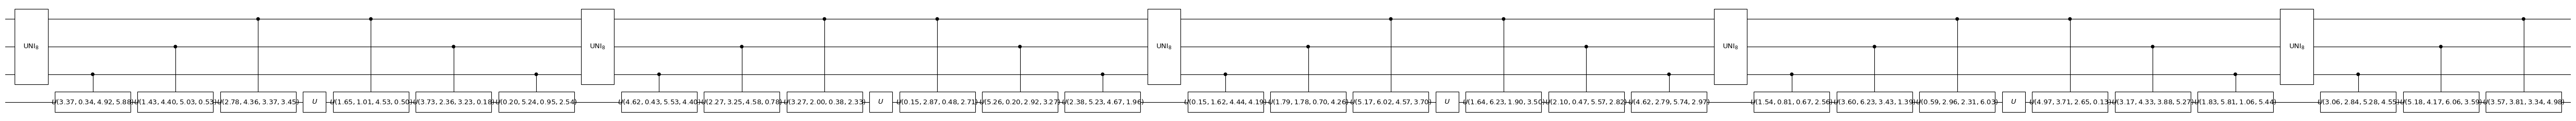

[pqcomb_dagger | process | 328809 | 0	0.0533s] slot_dim: 2, slots: 4, aux_qubits: 3, LR: 1.00e-01, Loss: 0.73839861
[pqcomb_dagger | process | 328809 | 100	0.0463s] slot_dim: 2, slots: 4, aux_qubits: 3, LR: 1.00e-01, Loss: 0.22116790
[pqcomb_dagger | process | 328809 | 200	0.0457s] slot_dim: 2, slots: 4, aux_qubits: 3, LR: 1.00e-01, Loss: 0.16390090
[pqcomb_dagger | process | 328809 | 300	0.0411s] slot_dim: 2, slots: 4, aux_qubits: 3, LR: 1.00e-01, Loss: 0.14052525
[pqcomb_dagger | process | 328809 | 400	0.0185s] slot_dim: 2, slots: 4, aux_qubits: 3, LR: 1.00e-01, Loss: 0.12033288
[pqcomb_dagger | process | 328809 | 500	0.0190s] slot_dim: 2, slots: 4, aux_qubits: 3, LR: 1.00e-02, Loss: 0.11601311
[pqcomb_dagger | process | 328809 | 600	0.0183s] slot_dim: 2, slots: 4, aux_qubits: 3, LR: 1.00e-02, Loss: 0.11423247
[pqcomb_dagger | process | 328809 | 700	0.0167s] slot_dim: 2, slots: 4, aux_qubits: 3, LR: 1.00e-02, Loss: 0.11229757
[pqcomb_dagger | process | 328809 | 800	0.0173s] slot_dim:

In [5]:
V_circuit_list_b = ModuleList()
for i in range(num_V):
    V_circuit = Circuit(num_qubits)
    if i > 0:
        V_circuit.cu([0, 3])
        V_circuit.cu([1, 3])
        V_circuit.cu([2, 3])
    V_circuit.universal_qudits(list(range(ancilla_qubits)))
    V_circuit.cu([2, 3])
    V_circuit.cu([1, 3])
    V_circuit.cu([0, 3])
    V_circuit_list_b.append(V_circuit)
net.V_circuit_list = V_circuit_list_b
net.plot()
net.train()

The ansatz further improved by guessing most of universal qubit-gates to be Pauli operators, and the first universal three-qubit gates to be Hadamard gates. The best training fidelity can approach 0.999 at this stage.

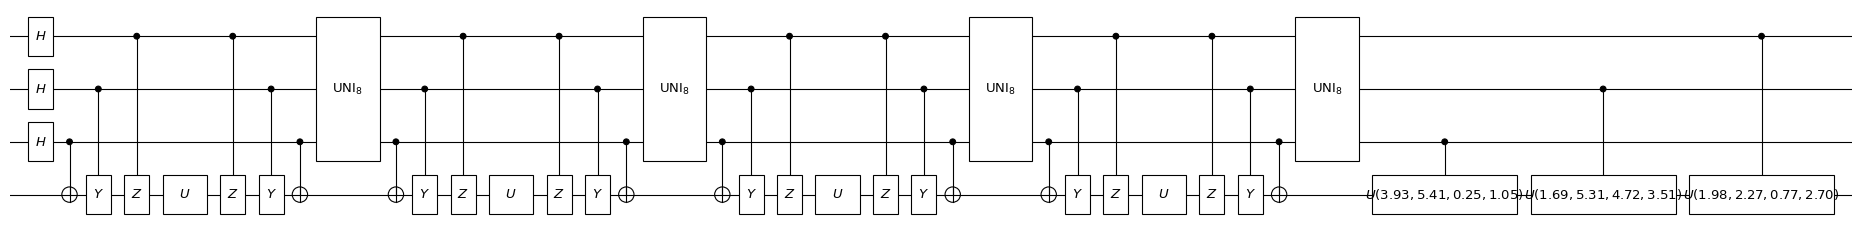

[pqcomb_dagger | process | 328809 | 0	0.0119s] slot_dim: 2, slots: 4, aux_qubits: 3, LR: 1.00e-01, Loss: 0.75666347
[pqcomb_dagger | process | 328809 | 100	0.0134s] slot_dim: 2, slots: 4, aux_qubits: 3, LR: 1.00e-01, Loss: 0.02438111
[pqcomb_dagger | process | 328809 | 200	0.0133s] slot_dim: 2, slots: 4, aux_qubits: 3, LR: 1.00e-01, Loss: 0.00673604
[pqcomb_dagger | process | 328809 | 300	0.0131s] slot_dim: 2, slots: 4, aux_qubits: 3, LR: 1.00e-02, Loss: 0.00295625
[pqcomb_dagger | process | 328809 | 400	0.0133s] slot_dim: 2, slots: 4, aux_qubits: 3, LR: 1.00e-02, Loss: 0.00260128
[pqcomb_dagger | process | 328809 | 500	0.0133s] slot_dim: 2, slots: 4, aux_qubits: 3, LR: 1.00e-02, Loss: 0.00225602
[pqcomb_dagger | process | 328809 | 600	0.0138s] slot_dim: 2, slots: 4, aux_qubits: 3, LR: 1.00e-02, Loss: 0.00193514
[pqcomb_dagger | process | 328809 | 700	0.0136s] slot_dim: 2, slots: 4, aux_qubits: 3, LR: 1.00e-02, Loss: 0.00164676
[pqcomb_dagger | process | 328809 | 800	0.0135s] slot_dim:

In [6]:
V_circuit_list_c = ModuleList()
for i in range(num_V):
    V_circuit = Circuit(num_qubits)
    if i == 0:
        V_circuit.h(list(range(ancilla_qubits)))
    else:
        V_circuit.cz([0, 3])
        V_circuit.cy([1, 3])
        V_circuit.cx([2, 3])
        V_circuit.universal_qudits(list(range(ancilla_qubits)))

    if i < num_slots:
        V_circuit.cx([2, 3])
        V_circuit.cy([1, 3])
        V_circuit.cz([0, 3])
    else:
        V_circuit.cu([2, 3])
        V_circuit.cu([1, 3])
        V_circuit.cu([0, 3])
    V_circuit_list_c.append(V_circuit)
net.V_circuit_list = V_circuit_list_c
net.plot()
net.train()

The ansatz further improved by guessing low coherence of the first ancilla qubit, which needs to be clean at the end: the amplitude on $\ket{0}$ is now proportional to the training fidelity.

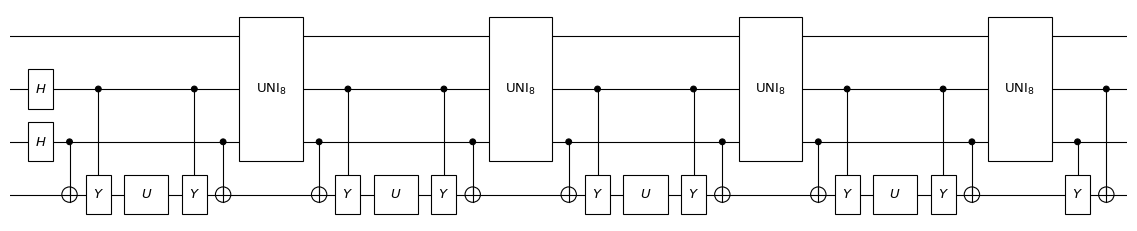

[pqcomb_dagger | process | 328809 | 0	0.0124s] slot_dim: 2, slots: 4, aux_qubits: 3, LR: 1.00e-01, Loss: 0.80868440
[pqcomb_dagger | process | 328809 | 100	0.0127s] slot_dim: 2, slots: 4, aux_qubits: 3, LR: 1.00e-01, Loss: 0.06523817
[pqcomb_dagger | process | 328809 | 200	0.0127s] slot_dim: 2, slots: 4, aux_qubits: 3, LR: 1.00e-01, Loss: 0.01286894
[pqcomb_dagger | process | 328809 | 300	0.0124s] slot_dim: 2, slots: 4, aux_qubits: 3, LR: 1.00e-02, Loss: 0.00319327
[pqcomb_dagger | process | 328809 | 400	0.0130s] slot_dim: 2, slots: 4, aux_qubits: 3, LR: 1.00e-02, Loss: 0.00267152
[pqcomb_dagger | process | 328809 | 500	0.0126s] slot_dim: 2, slots: 4, aux_qubits: 3, LR: 1.00e-02, Loss: 0.00222767
[pqcomb_dagger | process | 328809 | 600	0.0132s] slot_dim: 2, slots: 4, aux_qubits: 3, LR: 1.00e-02, Loss: 0.00184315
[pqcomb_dagger | process | 328809 | 700	0.0129s] slot_dim: 2, slots: 4, aux_qubits: 3, LR: 1.00e-02, Loss: 0.00152003
[pqcomb_dagger | process | 328809 | 800	0.0122s] slot_dim:

In [7]:
V_circuit_list_d = ModuleList()
for i in range(num_V):
    V_circuit = Circuit(num_qubits)
    if i == 0:
        V_circuit.h(list(range(1, ancilla_qubits)))
    else:
        V_circuit.cy([1, 3])
        V_circuit.cx([2, 3])
        V_circuit.universal_qudits(list(range(ancilla_qubits)))

    if i < num_slots:
        V_circuit.cx([2, 3])
        V_circuit.cy([1, 3])
    else:
        V_circuit.cy([2, 3])
        V_circuit.cx([1, 3])
    V_circuit_list_d.append(V_circuit)
net.V_circuit_list = V_circuit_list_d
net.plot()
net.train(
    projector=zero_state(1).density_matrix.kron(torch.eye(2 ** (ancilla_qubits - 1)))
)

In [8]:
quairkit.print_info()


---------VERSION---------
quairkit: 0.2.0
torch: 2.5.1+cu124
torch cuda: 12.4
numpy: 1.26.4
scipy: 1.14.1
matplotlib: 3.9.3
---------SYSTEM---------
Python version: 3.10.15
OS: Linux
OS version: #1 SMP Tue Nov 5 00:21:55 UTC 2024
---------DEVICE---------
CPU:  13th Gen Intel(R) Core(TM) i9-13980HX
GPU: (0) NVIDIA GeForce RTX 4090 Laptop GPU
